In [1]:
%run -m celldom.nb.logging
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
import celldom
import glob
import plotnine as pn
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from celldom.core import cytometry
from celldom.config import experiment_config

In [2]:
data_dir = '/lab/data/celldom/output/experiment_01'

In [3]:
store = cytometry.get_readonly_datastore(data_dir)

In [4]:
apt_data = store.get('table_apartment')

In [5]:
#acq_data = store.get('table_acquisition')

In [6]:
import plotnine as pn

In [7]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12096 entries, 0 to 12
Data columns (total 35 columns):
acq_apartment             12096 non-null object
acq_chip                  12096 non-null object
acq_cohort                12096 non-null object
acq_concentration         12096 non-null object
acq_datetime              12096 non-null datetime64[ns]
acq_id                    12096 non-null object
acq_processed_at          12096 non-null datetime64[ns]
acq_street                12096 non-null object
acq_z                     12096 non-null object
apt_id                    12096 non-null int64
apt_image_height          12096 non-null int64
apt_image_width           12096 non-null int64
apt_num                   12096 non-null object
apt_num_digit_scores      12096 non-null object
cell_area_mean            12028 non-null float64
cell_area_p10             12028 non-null float64
cell_area_p50             12028 non-null float64
cell_area_p90             12028 non-null float64
cell_area_std

In [8]:
group_cols = ['acq_cohort', 'st_num', 'apt_num']
df = apt_data[group_cols + ['cell_count', 'acq_datetime']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12096 entries, 0 to 12
Data columns (total 5 columns):
acq_cohort      12096 non-null object
st_num          12096 non-null object
apt_num         12096 non-null object
cell_count      12096 non-null int64
acq_datetime    12096 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 567.0+ KB


In [9]:
df['acq_datetime'].min()

Timestamp('2018-05-31 16:10:00')

In [10]:
from sklearn.linear_model import LinearRegression
def get_growth_coef(g):
    if len(g) < 2:
        return np.nan
    assert np.all(g['cell_count'] >= 0)
    
    time = g['elapsed_hours'].values / 24 # Convert to days
    X = np.expand_dims(time, -1)
    y = np.log2(g['cell_count'] + 1)
    m = LinearRegression().fit(X, y)
    return m.coef_[0]

In [11]:
# acq_id, acq_datetime, apt_id, st_num, apt_num, cell_count
def compute_growth_rates(df, start_of_experiment, group_cols, agg_fn=np.median):
    
    d = df.copy()
    d['elapsed_hours'] = (d['acq_datetime'] - start_of_experiment) / np.timedelta64(1, 'h')
    d = d.groupby(group_cols + ['elapsed_hours']).agg({'cell_count': agg_fn}).reset_index()
    
    print(d.groupby(group_cols).size().value_counts())
    d = d.groupby(group_cols).apply(get_growth_coef).rename('growth_rate')
    return d.reset_index()
dfg = compute_growth_rates(df, pd.to_datetime('2018-05-31 16:10:00'), group_cols, agg_fn=np.median)

3     685
2     640
1     590
4     541
5     313
6     159
7      83
8      31
9      12
10      2
dtype: int64


In [12]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 4 columns):
acq_cohort     3056 non-null object
st_num         3056 non-null object
apt_num        3056 non-null object
growth_rate    2466 non-null float64
dtypes: float64(1), object(3)
memory usage: 95.6+ KB


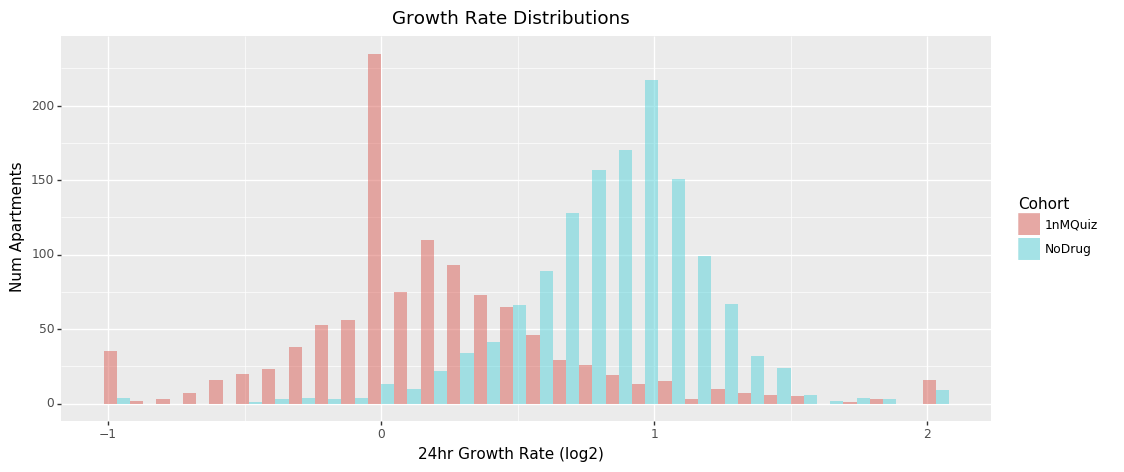

<ggplot: (-9223363260020445752)>

In [13]:
dfp = dfg.copy()
dfp = dfp[dfp['growth_rate'].notnull()]
dfp['growth_rate'] = dfp['growth_rate'].clip(-1, 2)
p = (
    pn.ggplot(dfp, pn.aes(x='growth_rate', fill='acq_cohort')) +
    pn.geom_histogram(alpha=.5, position='dodge', bins=32) + 
    pn.scale_fill_discrete(guide=pn.guide_legend(title='Cohort')) +
    pn.theme(figure_size=(12, 5)) + 
    pn.xlab('24hr Growth Rate (log2)') +
    pn.ylab('Num Apartments') +
    pn.ggtitle('Growth Rate Distributions')
)
p

In [14]:
dfg['apt_num'].nunique()

107

In [62]:
# dfp = dfg.copy()
# dfp = dfp[dfp['growth_rate'].notnull()]
# dfp['apt_num'] = dfp['apt_num'].astype(np.int)
# dfp = dfp[dfp['apt_num'] < 60]
# dfp = dfp.groupby(['apt_num', 'acq_cohort'])['growth_rate'].mean().reset_index()
# dfp.head()

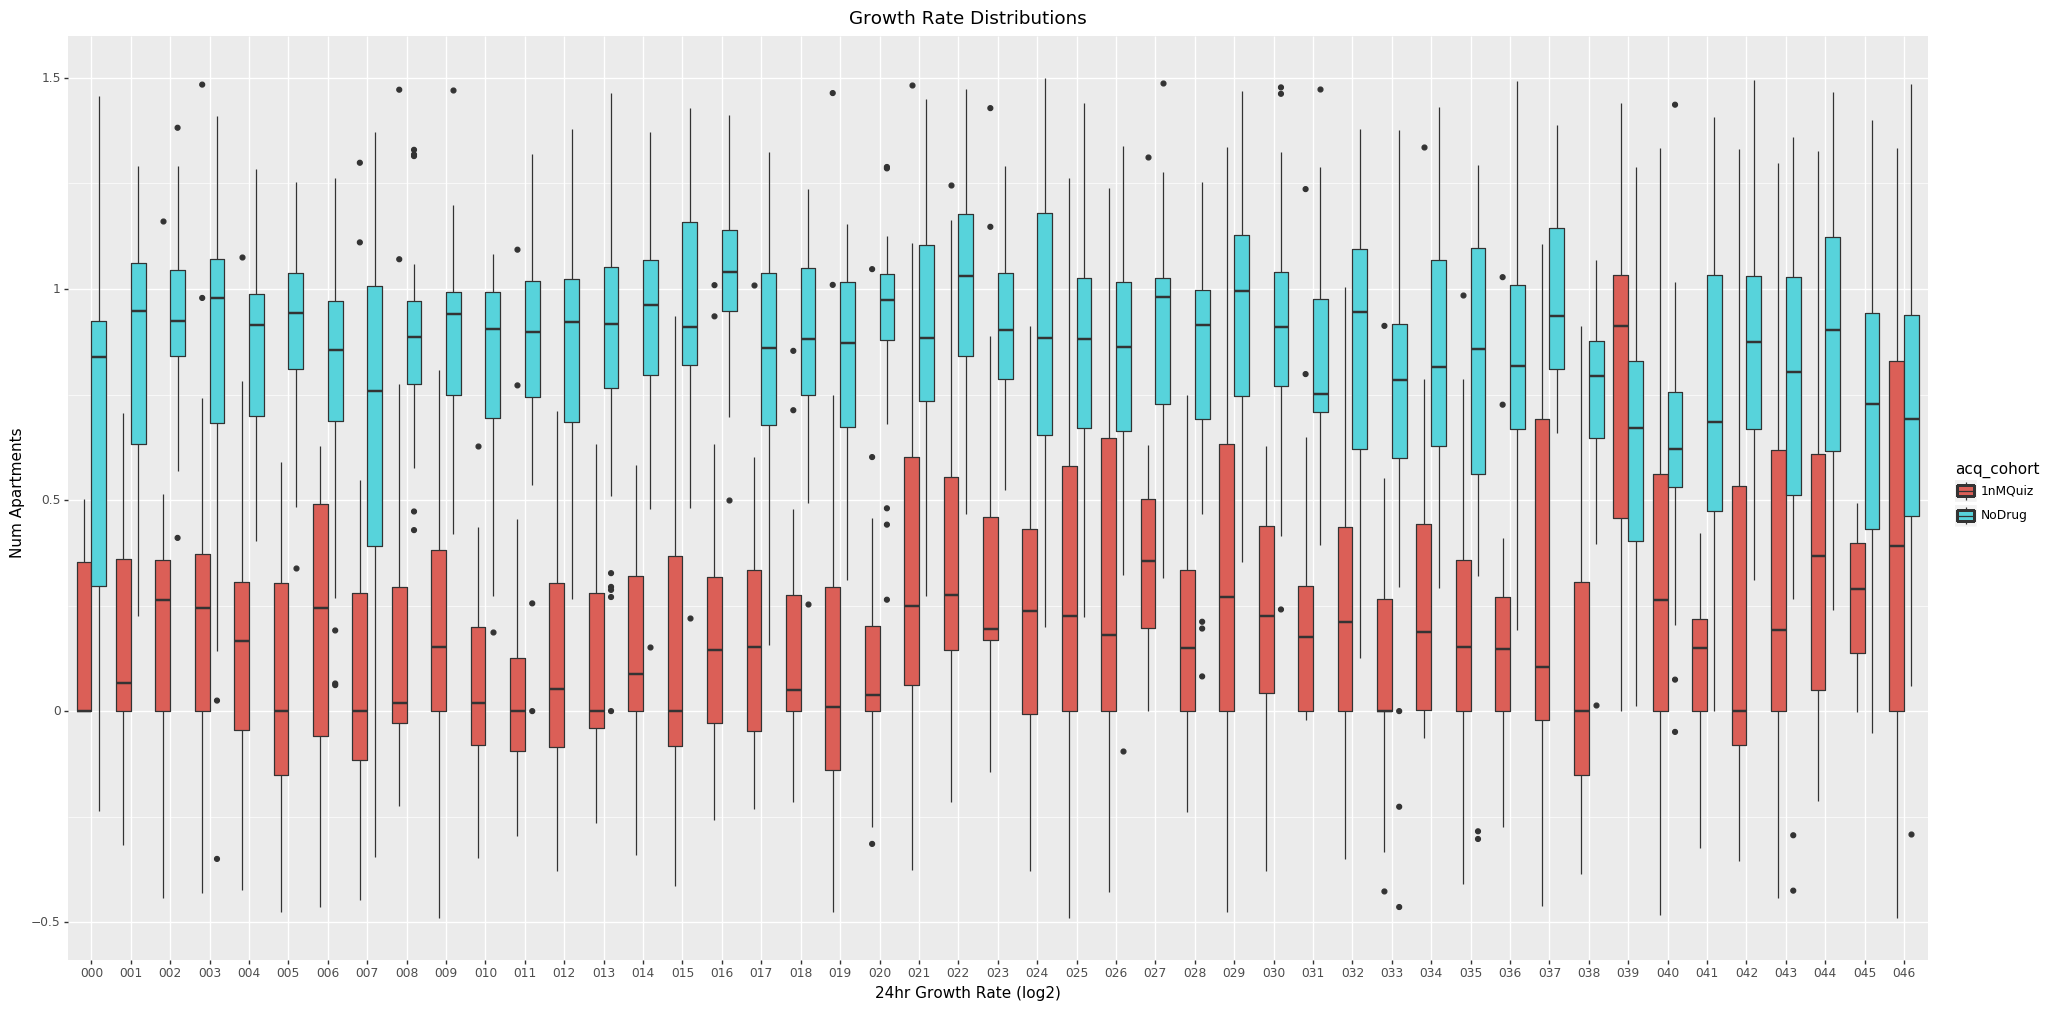

<ggplot: (8776834272583)>

In [15]:
dfp = dfg.copy()
dfp = dfp[dfp['growth_rate'].between(-.5, 1.5)]
dfp = dfp[dfp['apt_num'].astype(np.int) < 50]
p = (
    pn.ggplot(dfp, pn.aes(x='apt_num', y='growth_rate', fill='acq_cohort')) +
    pn.geom_boxplot(position='dodge') +
    pn.theme(figure_size=(24, 12)) + 
    pn.xlab('24hr Growth Rate (log2)') +
    pn.ylab('Num Apartments') +
    pn.ggtitle('Growth Rate Distributions')
)
p